# Object detection using Faster R-CNN trained on VOC dataset

### Import libraries

In [1]:
import os
import shutil
import random
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import torchvision as TV
from torchvision.transforms import functional as F

from PIL import Image

### Loading dataset and splitting it to Train, Validation and Test

In [2]:
dataset = datasets.VOCDetection(
    root='../../../../datasets/voc_detection',
    download=False, # Download = True if dataset is not available.
    image_set='train'
)

num_samples = len(dataset)

indices = list(range(num_samples))
random.seed(42)

train_indices, temp_indices = train_test_split(indices, test_size=0.4, random_state=42)
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

### A class to Extract Boundary boxes and labels for each image (transformed images)

In [3]:
class ExtractVOCDataset(Dataset):
    """
    A custom dataset for extracting and processing annotations from the Pascal VOC dataset.
    """

    def __init__(self, voc_dataset, label_map, transform=None):
        """
        Initializes the ExtractVOCDataset instance.

        Args:
            voc_dataset (Dataset): The base VOCDetection dataset.
            label_map (dict): A dictionary mapping class names to integer labels.
            transform (callable, optional): A function/transform to apply to the images and boxes.
        """
        super().__init__()
        self.voc_dataset = voc_dataset
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The number of samples in the dataset.
        """
        return len(self.voc_dataset)


    def _resize_boxes(self, boxes, original_size, new_size):
        """
        Rescales bounding boxes to match the resized image dimensions.

        Args:
            boxes (Tensor): A tensor of shape (N, 4) containing bounding boxes.
            original_size (tuple): The original dimensions of the image (height, width).
            new_size (tuple): The new dimensions of the image (height, width).

        Returns:
            Tensor: The resized bounding boxes.
        """
        orig_h, orig_w = original_size
        new_h, new_w = new_size

        scale_x = new_w / orig_w
        scale_y = new_h / orig_h

        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        return boxes
    

    def __getitem__(self, idx):
        """
        Retrieves the image and target annotations for a given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the processed image and the target annotations:
                - img (PIL.Image or Tensor): The image with transformations applied.
                - target (dict): A dictionary containing:
                    - 'boxes' (Tensor): A tensor of shape (N, 4) containing bounding boxes.
                    - 'labels' (Tensor): A tensor of shape (N,) containing class labels.
        """
        img, ann = self.voc_dataset[idx]

        orig_size = img.size

        objs = ann['annotation']['object']

        boxes = []
        labels = []

        for obj in objs:
            bbox = obj['bndbox']
            xmin = float(bbox['xmin'])
            ymin = float(bbox['ymin'])
            xmax = float(bbox['xmax'])
            ymax = float(bbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])

            label = self.label_map[obj['name']]
            labels.append(label)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        if self.transform:
            img = self.transform(img)

            if isinstance(self.transform, transforms.Compose):
                for t in self.transform.transforms:
                    if isinstance(t, transforms.Resize):
                        new_size = t.size if isinstance(t.size, tuple) else (t.size, t.size)
                        boxes = self._resize_boxes(boxes, (orig_size[1], orig_size[0]), new_size)

                target['boxes'] = boxes

        return img, target

### Extracting datasets images and its corresponding targets

In [4]:
# There is 20 different objects in pascal VOC dataset and one background (total 21 objects)
label_map = {
    'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5,
    'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10,
    'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15,
    'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_ds = ExtractVOCDataset(train_dataset, label_map, transform=transform)
val_ds = ExtractVOCDataset(val_dataset, label_map, transform=transform)
test_ds = ExtractVOCDataset(test_dataset, label_map, transform=transform)

In [5]:
print(f'Train size: {len(train_ds)} | Validate size: {len(val_ds)} | Test size: {len(test_ds)}')

Train size: 3430 | Validate size: 1143 | Test size: 1144


Custom collate function for dataloader to have same size for each load

In [6]:

def custom_collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)

    return torch.stack(images, dim=0), targets

train_dataloader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_ds, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_ds, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

Set device

In [7]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

### Using resnet50 as backbone and by default training 3 layers of it

In [8]:
def create_model(n_classes):
    model = TV.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')

    # Changing fully connected features in/out for our task (21 classes)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n_classes)

    return model

model = create_model(21)
model = model.to(device)

### Training the model

In [11]:
# Listing learnable parameters (model parameters which requires grad)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=1e-4, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in tqdm(train_dataloader):
        # Moving images and targets to given device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        # Computing losses (Classification loss + Bounding Box Regression Loss)
        losses: torch.Tensor = sum(loss for loss in loss_dict.values())
        train_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    lr_scheduler.step()
    print(f'Epoch {epoch + 1} | Train loss: {train_loss / len(train_dataloader)}')

# Saving the model
torch.save(model.state_dict(), f".\model_voc_detection.pth")

  0%|          | 0/858 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 5.17 GiB is allocated by PyTorch, and 102.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Visualizing the trained model

In [ ]:
def visualize_predictions(dataset, model, idx, label_map, device, score_threshold=0.5):
    """
    Visualize the ground truth and predictions for an image from the dataset.

    Args:
        dataset: The custom dataset (e.g., custom_dataset).
        model: The trained Faster R-CNN model.
        idx: Index of the image in the dataset to visualize.
        label_map: A dictionary mapping numerical labels to class names.
        device: The device (CPU or GPU) to use for inference.
        score_threshold: Minimum score for displaying predicted bounding boxes.
    """

    img, target = dataset[idx]
    # Set model to eval model for prediction
    model.eval()

    img_tensor = img.to(device)
    img_pil = to_pil_image(img_tensor)

    with torch.no_grad():
        prediction = model([img_tensor])[0]

    # Convert tensors to numpy arrays for plotting
    ground_truth_boxes = target['boxes'].cpu().numpy()
    ground_truth_labels = target['labels'].cpu().numpy()
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()

    # Plot the image
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(img_pil)
    ax[0].set_title("Ground Truth")
    ax[1].imshow(img_pil)
    ax[1].set_title("Predictions")

    # Plot ground truth bounding boxes
    for box, label in zip(ground_truth_boxes, ground_truth_labels):
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor="green",
            facecolor="none",
        )
        ax[0].add_patch(rect)
        ax[0].text(
            xmin, ymin, label_map[label], color="green", fontsize=10, weight="bold"
        )

    # Plot predicted bounding boxes
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        if score >= score_threshold:  # Filter by score threshold
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle(
                (xmin, ymin),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax[1].add_patch(rect)
            ax[1].text(
                xmin,
                ymin,
                f"{label_map[label]}: {score:.2f}",
                color="red",
                fontsize=10,
                weight="bold",
            )

    ax[0].axis('off')
    ax[1].axis('off')

    plt.show()

In [ ]:
label_map = {
    1: 'aeroplane', 2: 'bicycle', 3: 'bird', 4: 'boat', 5: 'bottle',
    6: 'bus', 7: 'car', 8: 'cat', 9: 'chair', 10: 'cow',
    11: 'diningtable', 12: 'dog', 13: 'horse', 14: 'motorbike', 15: 'person',
    16: 'pottedplant', 17: 'sheep', 18: 'sofa', 19: 'train', 20: 'tvmonitor'
}

In [ ]:
def visualize_model(model, dataset, label_map, device, score_threshold):
    random_idx = torch.randint(0, len(test_dataset), size=(1,))
    visualize_predictions(dataset, model, random_idx, label_map, device, score_threshold=score_threshold)

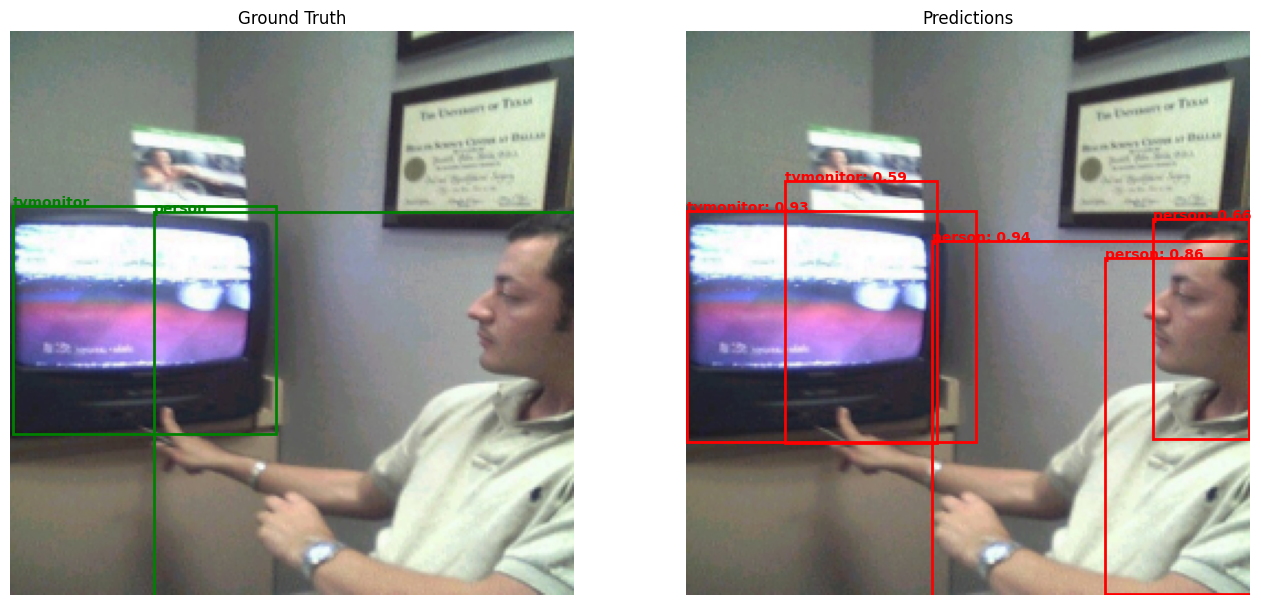

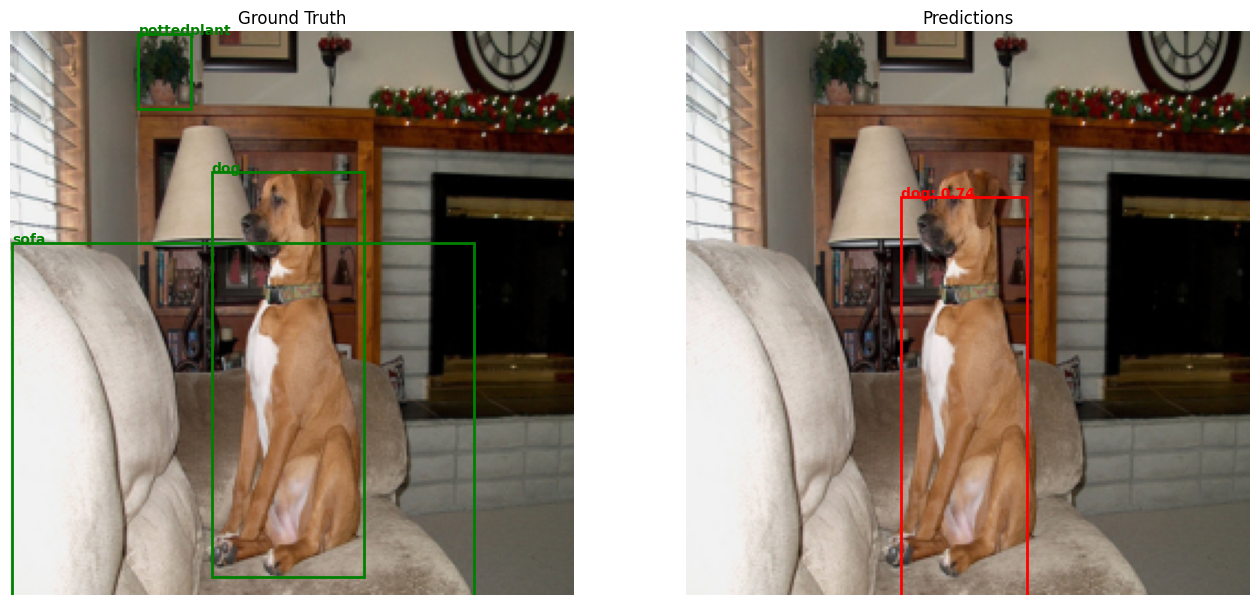

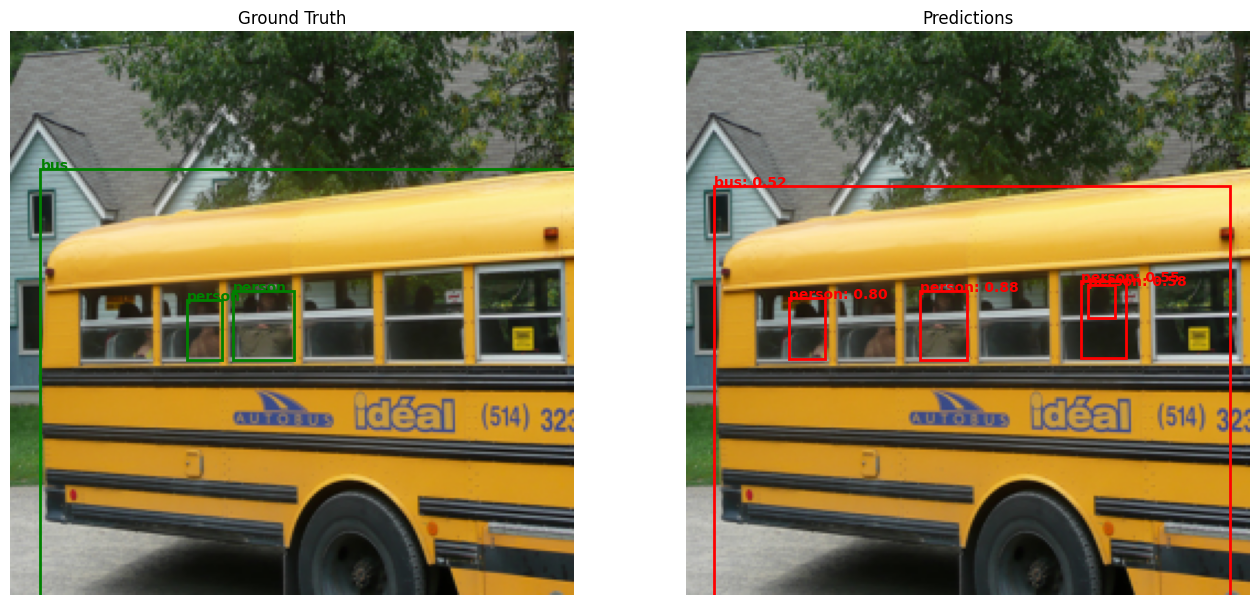

In [ ]:
visualize_model(model, test_ds, label_map, device, 0.5)
visualize_model(model, test_ds, label_map, device, 0.5)
visualize_model(model, test_ds, label_map, device, 0.5)

### Computing mAP measure

In [ ]:
metric = MeanAveragePrecision()

model.eval()
with torch.no_grad():
    for images, targets in tqdm(test_dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)

        metric.update(outputs, targets)

results = metric.compute()
print(results)

100%|██████████| 286/286 [02:20<00:00,  2.04it/s]


{'map': tensor(0.2767), 'map_50': tensor(0.5606), 'map_75': tensor(0.2236), 'map_small': tensor(0.1567), 'map_medium': tensor(0.2691), 'map_large': tensor(0.3425), 'mar_1': tensor(0.2880), 'mar_10': tensor(0.4564), 'mar_100': tensor(0.4781), 'mar_small': tensor(0.2912), 'mar_medium': tensor(0.4639), 'mar_large': tensor(0.5532), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20], dtype=torch.int32)}


Evaluation Metrics Summary:
---------------------------
1. Overall Performance:
   - mAP (Mean Average Precision, IoU=0.5:0.95):      27.67%
   - mAP (IoU=0.50):                                   56.06%
   - mAP (IoU=0.75):                                   22.36%

2. Performance by Object Size:
   - mAP for Small Objects (area < 32² pixels):        15.67%
   - mAP for Medium Objects (32² <= area <= 96²):      26.91%
   - mAP for Large Objects (area > 96² pixels):        34.25%

3. Recall Metrics:
   - Recall (Top 1 Prediction per Image):             28.80%
   - Recall (Top 10 Predictions per Image):           45.64%
   - Recall (Top 100 Predictions per Image):          47.81%
   - Recall for Small Objects:                        29.12%
   - Recall for Medium Objects:                       46.39%
   - Recall for Large Objects:                        55.32%

4. Class Information:
   - Total Classes Evaluated:                         20
   - Class Indices:                                   [1, 2, 3, ..., 20]

Note:
- mAP per class and Recall per class are not computed (`-1`).